In [1306]:
# Generate data array
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import math

# Data file selection criteria
mouse = 'b1003'
day = '06'
month = '01'
year = '2019'
folder = '/Users/torstensola/Google Drive/'

# Get file specified by mouse, year and day (prompt for action if > 1)
dataPath = []
print 'Available data files: \n'
for file in os.listdir(folder + mouse):
    if file.endswith(".txt"):
        if file.startswith(mouse + '_' + year + month + day):
            print(file)
            dataPath.append(file)

# Check if > 1 data file that day
if len(dataPath) > 1:
    sel = raw_input('\nMore than one data file that day, which one (between 1 and n)? ')
else:
    sel = 1
dataPath = folder + mouse + '/' + dataPath[int(sel)-1]
print('\nFile target: ' + dataPath + '\n\n\n\n\n')

Available data files: 

b1003_201901061805.txt

File target: /Users/torstensola/Google Drive/b1003/b1003_201901061805.txt







In [1307]:
# Serial arduino --> python delay used in code
vDelay = 100; #(ms)

# Read all the data and clean it up (remove unnecessary gaps)
mystr = []
with open(dataPath, 'r') as var:
    for line in var:
        line = line.rstrip()
        if len(line) > 0:
            mystr.append(line)

# Get event keys and corresponding time stamps (as ints) in separate lists
keys = []
values = []
errcount = 0
for i in mystr[4:-1]: # Slicing avoids the header and termination statement
    if i.count(':') == 1:
        a,b = i.split(":")
        if len(b) > 0:
            keys.append(a)
            values.append(int(b))
        else:
            errcount += 1
    else:
        errcount += 1

# Generate an array to hold the data
DA = np.zeros((len(values),11))
for i,j in enumerate(values):
    DA[i,0] = j
    DA[i,1] = ord(keys[i][0])

# Trial onset indices
ii = np.where(DA[:,1]==ord('X'))
Xidx = ii[0][:]
ii = np.where(DA[:,1]==ord('Q'))
# Stim onset indices
Qidx = ii[0][:]
np.append(Qidx,len(values)) # Pad the array for easy iterative processing
# Stim offset indices
ii = np.where(DA[:,1] == ord('W'))
Widx = ii[0][:]
# Lick indices
ii = np.where(DA[:,1] == ord('k'))
Kidx = ii[0][:]

# Add lick in/out discriminators to dataArray
for i in Kidx:
    DA[i,9] = int(keys[i][1:])

rewCount = 0
omCount = 0
for i,j in enumerate(Qidx):
    if i < len(Qidx)-1:
        DA[j:Qidx[i+1],2] = int(keys[Xidx[i]][1:]) # Trial number
        DA[j:Qidx[i+1],3] = values[j]  + vDelay # Extract all trial start times
        DA[j:Qidx[i+1],5] = keys[j][1] # Extract stimulus type (<3 is stim 1, >2 is stim 2)
        DA[j:Qidx[i+1],6] = values[Widx[i]] + vDelay # Extract stimulus onset for whole trial
        DA[j:Qidx[i+1],7] = values[j]-values[Xidx[i]] + vDelay # Extract stimulus onset
        
        # Check for rewarded VS omission trials
        testt = DA[j:Qidx[i+1],1] == ord('T') # Find reward key
        if testt.any():
            rewCount += 1
            DA[j:Qidx[i+1],4] = 1 # Rewarded
            DA[j:Qidx[i+1],8] = rewCount # Separate rewarded index
        else:
            omCount += 1
            DA[j:Qidx[i+1],4] = 0 # Not rewarded
            DA[j:Qidx[i+1],8] = omCount # Separate non-rewarded index
            
# Generate the dataframe column names
colnames = ['tstamp','key','trial','tstart','rew',
            'stimID','s1off','tstampa','rewn',
            'lickd','dpos']

# Genearte panda dataframe
DA = pd.DataFrame(DA,index=range(len(DA)),columns=colnames)

print 'Data errors: ', errcount

Data errors:  0


In [1308]:
# Example: extract all lick events and divide them according to whether they occurred in a rewarded or non-rewarded trial
stimD = DA.s1off[900]-DA.tstart[900]
stimD = stimD.astype(float)
s1 = DA.key == ord('k') # Find all licks (lick key = k)
s2_1 = DA.rew == 1 # Find all rewarded trials
s2_2 = DA.rew == 0 # Find all non-rewarded trials
s3 = (DA.tstamp - DA.tstart > 0) & (DA.tstamp - DA.tstart < (stimD-vDelay)) # Only include data points inside the visual stimulus presentation
s4 = (DA.tstamp - DA.tstart > (stimD-vDelay))
s5 = DA.trial < np.max(DA.trial)/2
cs1 = (s1)&(s2_1)&(s3)&(s5);    cs5 = (s1)&(s2_1)&(s3)&(~s5)
cs2 = (s1)&(s2_2)&(s3)&(s5);    cs6 = (s1)&(s2_2)&(s3)&(~s5)
cs3 = (s1)&(s2_1)&(s4)&(s5);    cs7 = (s1)&(s2_1)&(s4)&(~s5)
cs4 = (s1)&(s2_2)&(s4)&(s5);    cs8 = (s1)&(s2_2)&(s4)&(~s5)

lr1 = DA.tstamp[cs1]-DA.tstart[cs1] #
lnr1 = DA.tstamp[cs2]-DA.tstart[cs2] #
lrITI1 = DA.tstamp[cs3]-DA.tstart[cs3] #
lnrITI1 = DA.tstamp[cs4]-DA.tstart[cs4] #

lr2 = DA.tstamp[cs5]-DA.tstart[cs5] #
lnr2 = DA.tstamp[cs6]-DA.tstart[cs6] #
lrITI2 = DA.tstamp[cs7]-DA.tstart[cs7] #
lnrITI2 = DA.tstamp[cs8]-DA.tstart[cs8] #


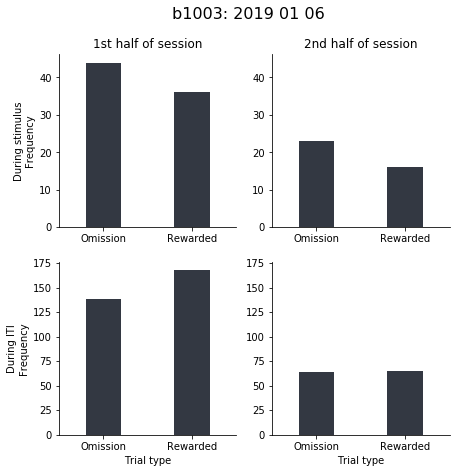

In [1309]:
# Plot differences in licks in rewarded vs non-rewarded trials
ymaxS = np.max([len(lnr1)/2,len(lr1)/2,len(lnr2)/2,len(lr2)/2])
ymaxITI = np.max([len(lnrITI1)/2,len(lrITI1)/2,len(lnrITI2)/2,len(lrITI2)/2])

f,axs = plt.subplots(nrows=2,ncols=2,sharex=True,sharey='row',figsize=(7,7))

axs[0,0].bar((2,4),
             (len(lnr1)/2,len(lr1)/2),
             facecolor=[.2,.22,.26])
axs[1,0].bar((2,4),
             (len(lnrITI1)/2,len(lrITI1)/2),
             facecolor=[.2,.22,.26])
axs[0,1].bar((2,4),
             (len(lnr2)/2,len(lr2)/2),
             facecolor=[.2,.22,.26])
axs[1,1].bar((2,4),
             (len(lnrITI2)/2,len(lrITI2)/2),
             facecolor=[.2,.22,.26])

axs[0,0].set_ylim([0, ymaxS*1.05])
axs[1,1].set_ylim([0, ymaxITI*1.05])

axs[0,1].set_title('2nd half of session')
axs[0,0].set_title('1st half of session')
axs[0,0].set_ylabel('During stimulus\nFrequency')
axs[1,0].set_ylabel('During ITI\nFrequency')

for ax in axs.reshape(-1): 
    ax.set_xticks([2,4])
    ax.set_xticklabels(['Omission','Rewarded'])
    ax.set_xlim((1,5))
for ax in axs[1,:]:
    ax.set_xlabel('Trial type')

for ax in axs.reshape(-1):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
f.text(.5,.95,mouse+': '+year+' '+month+' '+day,fontsize=16,ha='center')
f.savefig(folder + mouse + '/plots/bars/' + year + month + day  +"bars")

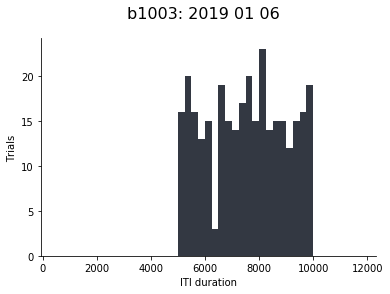

In [1310]:
# Plot ITI distribution
f,ax = plt.subplots(1)
ax.hist(DA.tstampa[DA.key == ord('Q')],
        np.arange(500,12000,250),
        facecolor=[.2,.22,.26])
ax.set_ylabel('Trials')
ax.set_xlabel('ITI duration')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

f.text(.5,.95,mouse+': '+year+' '+month+' '+day,fontsize=16,ha='center')
f.savefig(folder + mouse + '/plots/ITIdist/' + year + month + day  + "ITIdist")

In [1311]:
# Get ITI times for rewarded and omission trial for plotting below
arr = np.zeros((len(Qidx),1))
for i in range(len(Qidx)):
    arr[i] = DA.tstampa[Qidx[i]]
ITIl = abs((arr-min(arr[:-1]))/(max(arr[:-1])-min(arr[:-1])))
ITIl = ITIl/max(ITIl)
ITIlr = ITIl[DA.rew[Qidx] == 1]
ITIlnr = ITIl[DA.rew[Qidx] == 0]

ITIsort = sorted(range(len(ITIl)), key=lambda k: ITIl[k])

ITIsortr = sorted(range(len(ITIlr)), key=lambda k: ITIlr[k])
ITIsortnr = sorted(range(len(ITIlnr)), key=lambda k: ITIlnr[k])


In [1312]:
# Extact lick features for plotting
licks = []
rewards = []
rewardC = []
lickD = []

# Find min ITI
minITI = DA.tstampa[Qidx].tolist()
minITI.sort()
minITI = round(minITI[12],-3)

for j,i in enumerate(DA.tstamp[Qidx]):
    temp = np.where((DA.tstamp[Kidx] > i-2000.) & (DA.tstamp[Kidx] < (i+minITI + int(stimD))))
    s = temp[0][:]
    licks.append([DA.tstamp[Kidx[s]]-i])
    rewards.append(DA.rew[Qidx[j]])
    rewardC.append(DA.rewn[Qidx[j]])
    lickD.append([DA.lickd[Kidx[s]]])

In [1313]:
# Unpack array lick data for each trial
skipN = 0
licksUPr = []
rewcUPr = []
ITIcr = []
ITIco = []
licksUPo = []
rewcUPo = []
for j,jj in enumerate(Qidx):
    if (DA.trial[jj] > skipN) & (DA.trial[jj] < len(Qidx)-skipN):
        if len(licks[j]) > 0: # Only include trials with licks
            for i in licks[j]:
                if (rewards[j] == 1): # Rewarded and only lick in events
                    for kk,k in enumerate(i):
                        if (lickD[j][0].tolist()[kk] == 1):
                            licksUPr.append(k)
                            rewcUPr.append(DA.rewn[Qidx[j]])
                            ITIcr.append(DA.rewn[Qidx[ITIsort[j]]])
                elif (rewards[j] == 0): # Omission and only lick in events
                    for kk,k in enumerate(i):
                        if (lickD[j][0].tolist()[kk] == 1):
                            licksUPo.append(k)
                            rewcUPo.append(DA.rewn[Qidx[j]])
                            ITIco.append(DA.rewn[Qidx[ITIsort[j]]])

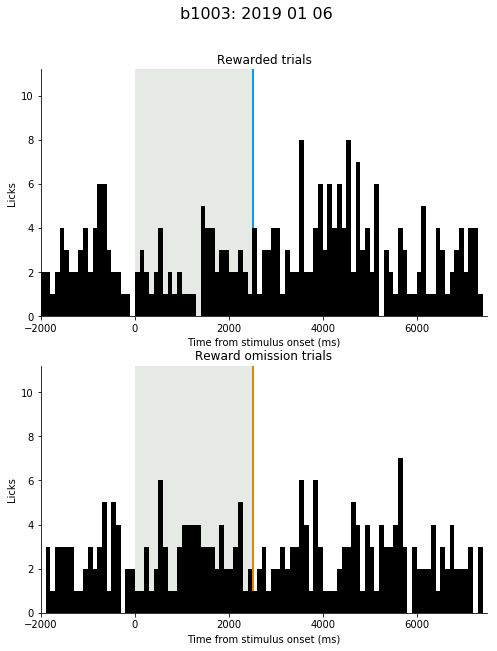

In [1314]:
# Plot PSTH
f,axs = plt.subplots(ncols=1,nrows=2,sharex=True,sharey=True,figsize = (8,10))
useblue = [0,.6,1]
usered = [.9,.5,0]
bins = axs[0].hist(licksUPr,
                   bins=np.arange(-2000,minITI+stimD,100),
                   facecolor = 'k')
bins2 = axs[1].hist(licksUPo,
                    bins=np.arange(-2000,minITI+stimD,100),
                    facecolor = 'k')

axs[0].fill_betweenx([0,max(bins[0]+bins2[0])*1.1],
                     [stimD,stimD],
                     [stimD+30,stimD+30],
                     facecolor=useblue,
                     alpha=1)
axs[1].fill_betweenx([0,max(bins[0]+bins2[0])*1.1],
                     [stimD,stimD],
                     [stimD+30,stimD+30],
                     facecolor=usered,
                     alpha=1)

axs[0].set_xlim([-2000,minITI+stimD])
axs[0].set_ylim([0,max(bins[0]+bins2[0])*.8])
axs[0].set_title('Rewarded trials')
axs[1].set_title('Reward omission trials')
for ax in axs:
    ax.set_xlabel('Time from stimulus onset (ms)')
    ax.set_ylabel('Licks')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.fill_betweenx([0,max(bins[0]+bins2[0])*1.1],
                     [stimD,stimD],
                     facecolor=[.5,.6,.5],
                     alpha=.2)
    
f.text(.5,.95,mouse+': '+year+' '+month+' '+day,fontsize=16,ha='center')
f.savefig(folder + mouse + '/plots/PSTH/' + year + month + day  + "PSTH")

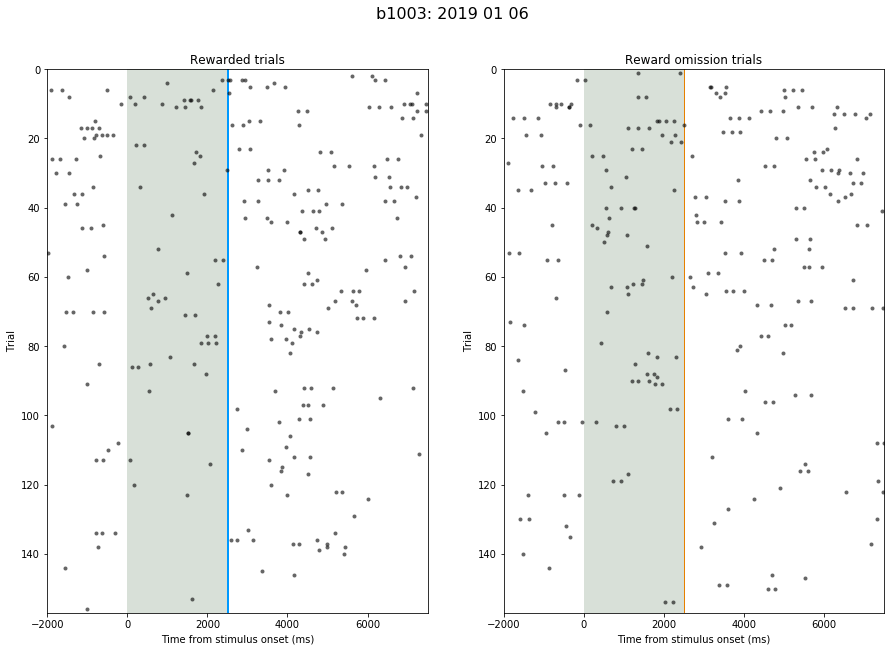

In [1315]:
# Plot lick raster plot
doITIsort = 0
showITI = 0
f,axs = plt.subplots(ncols=2,nrows=1,sharex=True,sharey=True,figsize=(15,10))
if doITIsort:
    axs[0].plot(licksUPr,
                ITIcr,'.k',
                alpha=.6,
                markersize=8,
                markeredgewidth=0)
    axs[1].plot(licksUPo,
                ITIco,'.k',
                alpha=.6,
                markersize=8,
                markeredgewidth=0)
    
    if showITI:
        # Add color coding for ITI duration per trial:
        for i in range(len(ITIlr)):
            s = ITIsortr[i]
            axs[0].fill_betweenx([i-.5,i+.5],-2000,0,
                                 facecolor=[float(ITIlr[s]),float(ITIlr[s]),1],
                                 alpha=.25)
        for i in range(len(ITIlnr)):
            s = ITIsortnr[i]
            axs[1].fill_betweenx([i-.5,i+.5],-2000,0,
                                 facecolor=[float(ITIlnr[s]),float(ITIlnr[s]),1],
                                 alpha=.25)
        
else:
    axs[0].plot(licksUPr,rewcUPr,'.k',
                alpha=.6,
                markersize=8,
                markeredgewidth=0)
    
    axs[1].plot(licksUPo,rewcUPo,'.k',
                alpha=.6,
                markersize=8,
                markeredgewidth=0)
    
    if showITI:
        # Add color coding for ITI duration per trial:
        for i in range(len(ITIlr)):
            axs[0].fill_betweenx([i-.5,i+.5],-2000,0,
                                 facecolor=[float(ITIlr[i]),float(ITIlr[i]),1],
                                 alpha=.25)
        for i in range(len(ITIlnr)):
            axs[1].fill_betweenx([i-.5,i+.5],-2000,0,
                                 facecolor=[float(ITIlnr[i]),float(ITIlnr[i]),1],
                                 alpha=.25)

for ax in axs:
    ax.set_ylabel('Trial')
    ax.set_xlabel('Time from stimulus onset (ms)')
    ax.fill_betweenx([0,np.max(DA.trial)],[stimD,stimD],
                     facecolor=[.5,.6,.5],
                     alpha=.3)
    
axs[0].set_xlim([-2000,minITI+stimD])
axs[0].set_ylim([0,np.max(DA.trial)/2+1])
axs[0].set_title('Rewarded trials')
axs[0].fill_betweenx([0,np.max(DA.trial)],[stimD,stimD],[stimD+30,stimD+30],
                     facecolor=useblue,
                     alpha=1)
axs[0].invert_yaxis()

axs[1].set_title('Reward omission trials')
axs[1].fill_betweenx([0,np.max(DA.trial)],[stimD,stimD],[stimD+30,stimD+30],
                     facecolor=usered,
                     alpha=1)
for ax in axs:
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
f.text(.5,.95,mouse+': '+year+' '+month+' '+day,fontsize=16,ha='center')
f.savefig(folder + mouse + '/plots/lickraster/' + year + month + day  + "lickraster")



In [1316]:
# Get treadmill position WORKS
ii = np.where(DA.key == ord('j'))
Jidx = ii[0][:]
Jvalues = []
Jtstamps = []
for i,j in enumerate(Jidx):
    Jvalues.append(int(keys[j][1:]))
    Jtstamps.append(DA.tstamp[j])

In [1317]:
# Get delta position and linearize WORKS
JdiffN = np.zeros((len(Jvalues),1))
Jdiff = np.diff(Jvalues)
Jtdiff = np.diff(Jtstamps)
for i,j in enumerate(Jdiff):
    if (abs(j) > 800) and (i < len(Jvalues)-3):
        JdiffN[i] = np.mean(Jdiff[[(i-1),(i+2)]])/Jtdiff[i]
    else:
        JdiffN[i] = j/Jtdiff[i]

for i,j in enumerate(Jidx):
    DA.dpos[j] = JdiffN[i]

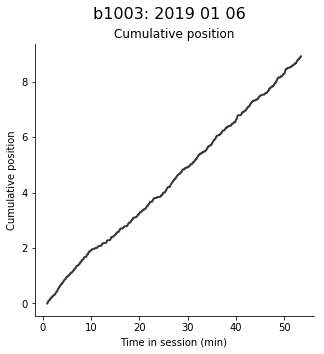

In [1318]:
f,ax = plt.subplots(1,figsize=(5,5))
ax.plot(DA.tstamp[Jidx]/1000/60, 
        np.cumsum(JdiffN)/5120,
        color=[.2,.22,.26],
        linewidth = 2)

ax.set_title('Cumulative position')
ax.set_xlabel('Time in session (min)')
ax.set_ylabel('Cumulative position')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
f.text(.5,.95,mouse+': '+year+' '+month+' '+day,fontsize=16,ha='center')
f.savefig(folder + mouse + '/plots/sessionpos/' + year + month + day  + "sessionpos")

In [1319]:
# Pull out treadmill data
treadstamp = []
treadreward = []
rewardN = []
position = []
for j,i in enumerate(DA.tstamp[Qidx]):
    temp = np.where((DA.tstamp[Jidx] > i-2000) & (DA.tstamp[Jidx] <= i+minITI+stimD))
    s = temp[0][:]
    treadstamp.append([DA.tstamp[Jidx[s]]-i])
    treadreward.append(DA.rew[Qidx[j]])
    rewardN.append(DA.rewn[Qidx[j]])
    position.append([DA.dpos[Jidx[s]]])

In [1320]:
# Unpack treadmill values
velocityR = []
trialR = []
tstampR = []
rewnR = []

velocityO = []
trialO = []
tstampO = []
rewnO = []
for j in range(len(Qidx)):
    if len(position[j]) > 0:
        for i in position[j]:
            if (treadreward[j] == 1):
                for k in i:
                    velocityR.append(k)
                    trialR.append(DA.trial[Qidx[j]])
                    rewnR.append(DA.rewn[Qidx[j]])
            elif (treadreward[j] == 0):
                for k in i:
                    velocityO.append(k)
                    trialO.append(j)
                    rewnO.append(DA.rewn[Qidx[j]])
        for i in treadstamp[j]:
            if (treadreward[j] == 1):
                for k in i:
                    tstampR.append(k)
            elif (treadreward[j] == 0):
                for k in i:
                    tstampO.append(k)

Max/min velocity:  4.575 -0.65


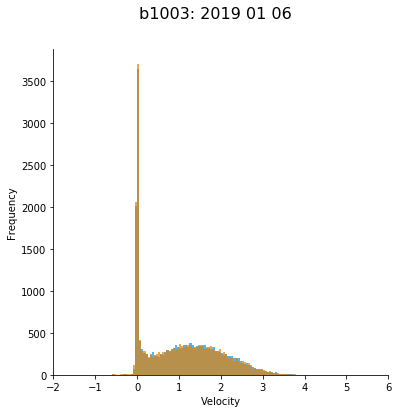

In [1321]:
# Plot velocity distributions for rewarded and omission trials
f,axs = plt.subplots(1,figsize=(6,6))

axs.hist(velocityR,
         bins=np.arange(-2,6,.05),
         alpha=.7,
         color=useblue)
axs.hist(velocityO,
         bins=np.arange(-2,6,.05),
         alpha=.7,
         color=usered)

axs.set_xlim((-2,6))
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')
plt.xlabel('Velocity')
plt.ylabel('Frequency')

print 'Max/min velocity: ', max(velocityO), min(velocityR)
f.text(.5,.95,mouse+': '+year+' '+month+' '+day,fontsize=16,ha='center')
f.savefig(folder + mouse + '/plots/velocitydist/' + year + month + day  + "velocitydist")

In [1322]:
# Figure out bins for step plot
wBins = 0.1
nSec = (minITI+stimD+2000)/1000

tm = np.zeros((int(nSec/wBins)+1,1+int(max(rewnR))))
tm2 = np.zeros((int(nSec/wBins)+1,1+int(max(rewnO))))
for j,i in enumerate(tstampR):
    tm[int(math.ceil(i/1000/wBins+2/wBins)),int(rewnR[j])] = tm[int(math.ceil(i/1000/wBins+2/wBins)),
                                                            int(rewnR[j])] + velocityR[j]
for j,i in enumerate(tstampO):
    tm2[int(math.ceil(i/1000/wBins+2/wBins)),int(rewnO[j])] = tm2[int(math.ceil(i/1000/wBins+2/wBins)),
                                                              int(rewnO[j])] + velocityO[j]
tm = tm[1:]
tm2 = tm2[1:]

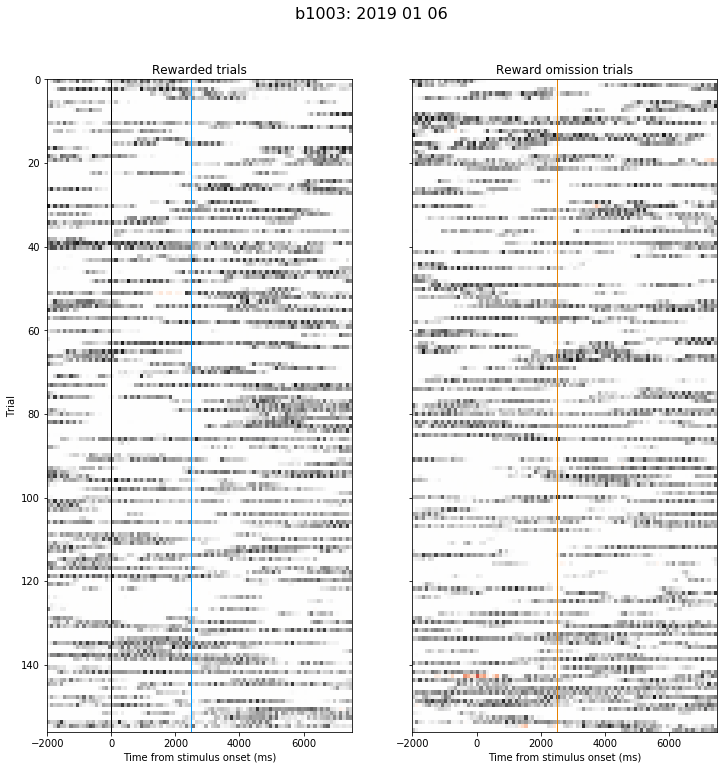

In [1323]:
f,axs = plt.subplots(ncols=2,figsize=(12,12),sharey=True,sharex=True)
axs[0].imshow(tm.T,
              cmap='RdGy',
              clim=((-9,9)),
              extent=[-2000,minITI+stimD,0,max(rewnR)],
              aspect='auto')
axs[1].imshow(tm2.T,
              cmap='RdGy',
              clim=((-9,9)),
              extent=[-2000,minITI+stimD,0,max(rewnO)],
              aspect='auto')
for ax in axs:
    ax.set_xlabel('Time from stimulus onset (ms)')
axs[1].fill_betweenx([0,np.max(DA.trial)],
                     [30,30],
                     facecolor=[0,0,0],
                     alpha=1)
axs[0].fill_betweenx([0,np.max(DA.trial)],
                     [30,30],
                     facecolor=[0,0,0],
                     alpha=1)

axs[0].set_ylabel('Trial')
axs[0].set_xlim([-2000,minITI+stimD])
axs[0].set_ylim([0,max(rewnO)])
axs[0].set_title('Rewarded trials')
axs[0].fill_betweenx([0,np.max(DA.trial)],
                     [stimD,stimD],
                     [stimD+30,stimD+30],
                     facecolor=useblue,
                     alpha=1)
axs[0].invert_yaxis()

axs[1].set_title('Reward omission trials')
axs[1].fill_betweenx([0,np.max(DA.trial)],
                     [stimD,stimD],
                     [stimD+30,stimD+30],
                     facecolor=usered,
                     alpha=1)

f.text(.5,.95,mouse+': '+year+' '+month+' '+day,fontsize=16,ha='center')
f.savefig(folder + mouse + '/plots/runraster/' + year + month + day  + "runraster")

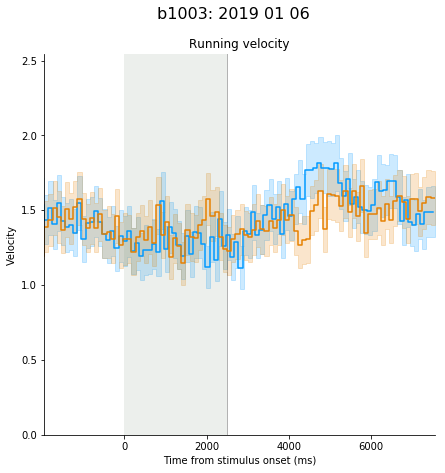

In [1324]:
f,axs = plt.subplots(1,figsize=(7,7))

axs.fill_between(np.linspace(-1950,int(minITI+stimD)+50,int(nSec/wBins)),
                 tm.mean(axis=1)+tm.std(axis=1)/np.sqrt(max(rewnR)),
                 tm.mean(axis=1)-tm.std(axis=1)/np.sqrt(max(rewnR)),
                 color=useblue,alpha = .2,step='pre')

axs.step(np.linspace(-1950,int(minITI+stimD),int(nSec/wBins)),
         tm.mean(axis=1),
         color=useblue)

axs.fill_between(np.linspace(-1950,int(minITI+stimD)+50,int(nSec/wBins)),
                 tm2.mean(axis=1)+tm2.std(axis=1)/np.sqrt(max(rewnO)),
                 tm2.mean(axis=1)-tm2.std(axis=1)/np.sqrt(max(rewnO)),
                 color=usered,alpha = .2,step='pre')

axs.step(np.linspace(-1950,int(minITI+stimD)+50,int(nSec/wBins)),
         tm2.mean(axis=1),
         color=usered)

axs.set_ylabel('Velocity')
axs.set_xlabel('Time from stimulus onset (ms)')
axs.fill_betweenx([0,max(np.mean(tm,axis=1)*1.4)],
                  [stimD,stimD],
                  facecolor=[.5,.6,.5],
                  alpha=.15)
    
axs.set_xlim([-1950,minITI+stimD+50])
axs.set_ylim([0,max(np.mean(tm,axis=1)*1.4)])
axs.set_title('Running velocity')
axs.fill_betweenx([0,max(np.mean(tm,axis=1)*1.4)],
                  [stimD,stimD],
                  [stimD+30,stimD+30],
                  facecolor=[0,0,0],
                  alpha=.3)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')
f.text(.5,.95,mouse+': '+year+' '+month+' '+day,fontsize=16,ha='center')
f.savefig(folder + mouse + '/plots/runPSTH/' + year + month + day  + "runPSTH")

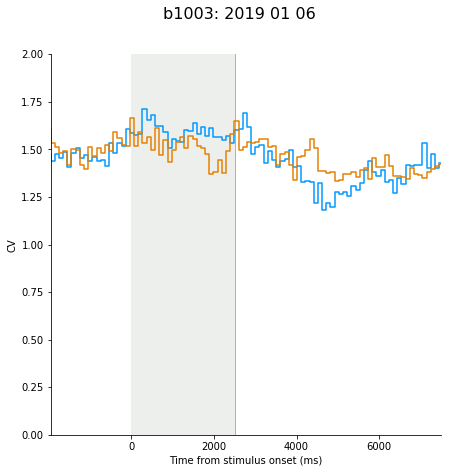

In [1325]:
cvR = np.zeros((len(tm),1))
cvO = np.zeros((len(tm2),1))

f,axs = plt.subplots(ncols=1,figsize=(7,7))

axs.step(np.linspace(-1950,int(minITI+stimD)+50,int(nSec/wBins)),
         tm.std(axis=1)/tm.mean(axis=1),color=useblue)

axs.step(np.linspace(-1950,int(minITI+stimD)+50,int(nSec/wBins)),
         tm2.std(axis=1)/tm2.mean(axis=1),color=usered)

axs.fill_betweenx([0,max(np.std(tm2,axis=1)/np.mean(tm2,axis=1)*1.2)],
                  [stimD,stimD],[stimD+30,stimD+30],
                  facecolor=[0,0,0],alpha=.3)

axs.set_ylabel('CV')
axs.set_xlim((-1950,minITI+stimD))
axs.set_xlabel('Time from stimulus onset (ms)')
axs.set_ylim([0,max(np.std(tm2,axis=1)/np.mean(tm2,axis=1)*1.2)])
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')
axs.set_xlabel('Time from stimulus onset (ms)')
axs.fill_betweenx([0,max(np.std(tm2,axis=1)/np.mean(tm2,axis=1)*1.2)],
                  [stimD,stimD],facecolor=[.5,.6,.5],alpha=.15)

f.text(.5,.95,mouse+': '+year+' '+month+' '+day,fontsize=16,ha='center')
f.savefig(folder + mouse + '/plots/runPSTHcv/' + year + month + day  + "runPSTHcv")


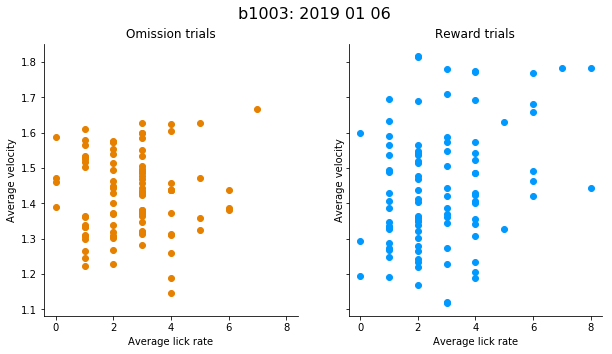

In [1326]:
f,axs = plt.subplots(ncols=2,figsize=(10,5),sharex=True,sharey=True)
axs[1].plot(bins[0],tm[1:].mean(axis=1),'o',color=useblue)
axs[0].set_title('Omission trials')
axs[1].set_title('Reward trials')
axs[0].plot(bins2[0],tm2[1:].mean(axis=1),'o',color=usered)
for ax in axs:
    ax.set_xlabel('Average lick rate')
    ax.set_ylabel('Average velocity')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
f.text(.5,.95,mouse+': '+year+' '+month+' '+day,fontsize=16,ha='center')
f.savefig(folder + mouse + '/plots/lickvelocity/' + year + month + day  + "lickvelocity")

In [56]:
# Add plot that tracks licks per trial for the two different Gabors across the session
trialLicksR = []
trialLicks = []
ITIlicksR = []
ITIlicks = []
selection1 = dataArray[:,1] == ord('k') # Find all licks (lick key = k)
selection2_1 = dataArray[:,4] == 1 # Find all rewarded trials
selection2_2 = dataArray[:,4] == 0 # Find all non-rewarded trials
selection3 = (dataArray[:,0] - dataArray[:,6] > 100) & (dataArray[:,0] - dataArray[:,6] < 1100) # Only include data points inside the visual stimulus presentation
selection4 = (dataArray[:,0] - dataArray[:,6] > 1100)

trialSel = np.arange(1)
for i in np.unique(dataArray[:,2]):
    selection5 = (dataArray[:,2] == i)
    
    combinedSelection1 = (selection1) & (selection2_1) & (selection3) & (selection5)
    combinedSelection2 = (selection1) & (selection2_2) & (selection3) & (selection5)
    combinedSelection3 = (selection1) & (selection2_1) & (selection4) & (selection5)
    combinedSelection4 = (selection1) & (selection2_2) & (selection4) & (selection5)

    trialLicksR.append(np.sum(combinedSelection1))
    trialLicks.append(np.sum(combinedSelection2))
    ITIlicksR.append(np.sum(combinedSelection3))
    ITIlicks.append(np.sum(combinedSelection4))
    

sigma = 2
x = np.arange(-6*sigma, 6*sigma, 1)
gaussian = np.exp(-(x/(2.*sigma))**2)/(np.sqrt(2.*np.pi*sigma**2))
result1 = np.convolve(trialLicksR, gaussian, mode="full")
result2 = np.convolve(trialLicks, gaussian, mode="full")
result3 = np.convolve(ITIlicksR, gaussian, mode="full")
result4 = np.convolve(ITIlicks, gaussian, mode="full")


plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.title('During stimulus presentation')
plt.plot(result1,'r')
plt.plot(result2,'k')
plt.ylabel('Licks/trial')
plt.ylim([0,np.max(result1+result2)])
plt.subplot(2,1,2)
plt.title('During ITI')
plt.ylim([0,np.max(result3+result4)])
plt.plot(result3,'r')
plt.plot(result4,'k')
plt.ylabel('Licks/trial')
plt.xlabel('Trial ID')
plt.show()

NameError: name 'dataArray' is not defined

In [ ]:
# Import an image from the Bethge lab image library for viewing single images
import numpy, array
plt.figure(figsize=(12,18))
i = 4001
filename1 = '/Users/hannestensola/Downloads/vanhateren_iml/imk{:05d}.iml'.format(i)

with open(filename1, 'rb') as handle:
   s = handle.read()
arr1 = array.array('H', s)
arr1.byteswap()
img1 = numpy.array(arr1, dtype='uint16').reshape(1024, 1536)

plt.imshow(img1**0.5, cmap='gray')

plt.show()

In [ ]:
#plt.plot(Jvalues)
#plt.show()

## THis is wrong
#test = Jvalues
#testt = []
#for i,j in enumerate(test):
#    if j > 1023:
#        testt.append(j-1023)
#    elif j < -1023:
#        testt.append(j+1023)
#    else:
#        testt.append(j)
#    
#plt.plot(np.cumsum(testt))
#plt.show()

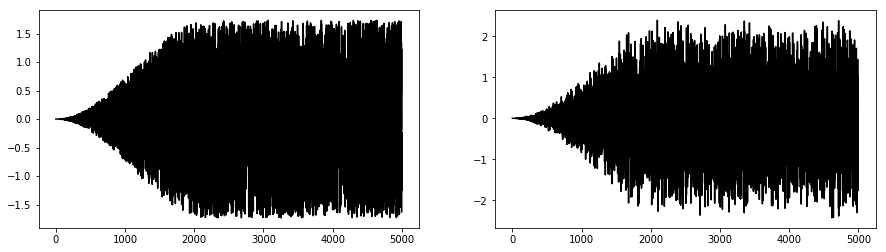

In [14]:
#% Generate noise stimuli
import numpy as np
import matplotlib.pyplot as plt
import psychopy
import sounddevice as sd

sFreq = 44100
dRamp = .05
N = 2.5
whitenoise = np.random.rand((int(N*sFreq)+1))*2-1
violetnoise = np.diff(whitenoise)/2
whitenoise = whitenoise[:-1]
whitenoise = whitenoise/np.sqrt(np.mean(whitenoise**2))
violetnoise = violetnoise/np.sqrt(np.mean(violetnoise**2))
# Apply onset and offset ramps
ramp = 0.5*np.cos(np.linspace(0,np.pi,int(sFreq*dRamp)))
envelp = np.ones((len(whitenoise),1))
envelp[:len(ramp),0] =  np.flip(ramp+.5)
envelp[-len(ramp):,0] =  ramp+.5

whitenoise = [a*b for a,b in zip(whitenoise,envelp)]
violetnoise = [a*b for a,b in zip(violetnoise,envelp)]

f, axs = plt.subplots(ncols=2,figsize=(15,4))
axs[0].plot(whitenoise[0:5000],'k')
axs[1].plot(violetnoise[0:5000],'k')


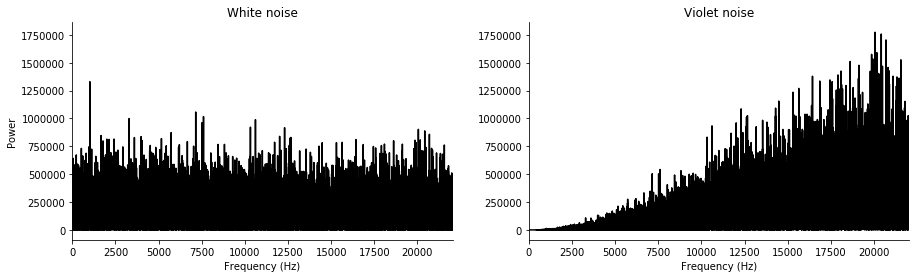

In [15]:
FSv = np.fft.fftn(violetnoise)
FSw = np.fft.fftn(whitenoise)
f, axs = plt.subplots(ncols=2,figsize=(15,4),sharex=True, sharey=True)
axs[1].plot(np.linspace(-sFreq/2,sFreq/2,len(whitenoise)),np.abs(np.fft.fftshift(FSv))**2,'k')
axs[0].plot(np.linspace(-sFreq/2,sFreq/2,len(whitenoise)),np.abs(np.fft.fftshift(FSw))**2,'k')
axs[0].set_xlim([0,sFreq/2])
axs[0].set_ylabel('Power')
axs[0].set_title('White noise')
axs[1].set_title('Violet noise')
for ax in axs: 
    ax.set_xlabel('Frequency (Hz)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [16]:
sd.play(whitenoise, sFreq)

In [17]:
sd.play(violetnoise, sFreq)